# Project: FBI Gun Interest Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling and Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Environment

This notebook uses version 1.4.1 of pandas, 1.22.3 of numpy, version 3.5.1 of matplotlib and version 0.11.2 version of seaborn and an addition library called missingno(used to visualize missign values). The code below is a guide to install it.
    
    pip install pandas == 1.4.1
    pip install numpy == 1.22.3
    pip install matplotlib == 3.5.1
    pip install seaborn == 0.11.2
    pip install missingno == 0.4.2

### Dataset

The dataset used for this analysis includes a [Gun dataset](https://www.google.com/url?q=https://d17h27t6h515a5.cloudfront.net/topher/2017/November/5a0a4db8_gun-data/gun-data.xlsx&sa=D&source=editors&ust=1653518238638898&usg=AOvVaw2a7Xdu7rQrz8PhbpTkUhU8) from the FBI's National Instant Criminal Background Check System ([NICS](https://www.fbi.gov/services/cjis/nics)) and [Census dataset](https://www.google.com/url?q=https://d17h27t6h515a5.cloudfront.net/topher/2017/November/5a0a554c_u.s.-census-data/u.s.-census-data.csv&sa=D&source=editors&ust=1653518238639365&usg=AOvVaw2ZKqhDj4Qv9I-avFSv6TG_) from the [United States Census Bureau](https://www.census.gov)


[Relevant link](https://www.fbi.gov/file-repository/2016-nics-operations-report-final-5-3-2017.pdf/view)

### Variables Description

We has 66 columns in the census dataset and and 27 columns. I am sure you are not ready to read 93 variable description(or are you?). I am just going to describe the 10 columns that made it to the last dataset.

* state: States in the United States of America
* population_est: Population estimate in 2016
* percent_pop_change: percentage of increase in population from 2010 to 2016
* percent_adult: percentage of people that are 18 or older in 2016
* percent_female: percentage of female population in 2016
* house_unit: Number of houses in 2016
* percent_old_no_ins: percentage of people that are 65 or older without insurance in 2016
* percent_poverty: Percentage of poor people in 2016
* totals: Total number of people interested in owning a gun in 2016
* gun_interest_change: percentage increase in totals from the previous year (2015)

If you are interested in what I considered when reducing the feature space and creating the final dataset.
* Data relevant for 2016 (data from later earlier dates where discard)
* Columns that didn't need other columns to bring meaningful analysis
* Data that summed up activites in 2016
* Columns that seem more important to the analysis

In [1]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno

#default configuration
pd.set_option("display.max_columns",10000000000090)
pd.set_option("display.max_colwidth",10000000000090)
sns.set(rc={"figure.figsize":(10,7)})
sns.set_style("darkgrid")

In [2]:
#some functions to reduce redundancy
def overview(df):
    """
    This function gives overview information on a dataset
    """
    print(f"There are {df.isna().sum().sum()} missing values" if df.isna().any().any() else "There are no missing values")
    print("-"*50)
    print(df.info())
    print("-"*50)
    print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    print("-"*50)
    return df.head()

def predict_population(current_population,growth_rate,number_of_years=10):
    """
    This function predicts the population given current population and growth rate
    """
    for i in range(number_of_years):
        current_population += current_population*growth_rate
    return current_population

def plot_missing_values(df):
    """
    This function visualizes missing values in a dataset
    """
    fig,ax = plt.subplots(figsize=(25,10))
    mno.matrix(df,sparkline=False,ax=ax,labels=True)
    ax.set_ylabel("Rows",fontsize=20)
    ax.set_xlabel("Columns",fontsize=20)
    ax.set_title("Visualization of missing values",fontsize=30);
    
def plot_bar(column1,column2,data,axis_label,title,rotate,annotate):
    """
    This function plots bar plots with seaborn and matplotlib
    """
    plot = sns.barplot(x=column1,y=column2,data=data);
    plot.set_xlabel(axis_label[0],fontsize=13)
    plot.set_ylabel(axis_label[1],fontsize=13)
    plot.set_title(title,fontsize=20)
    if rotate:
        plot.set_xticklabels(labels=plot.get_xticklabels(),rotation=45)
    if annotate:
        for bar in plot.patches:
            plot.annotate(format(bar.get_height(), '.1f'),
                           (bar.get_x() + bar.get_width() / 2,
                            bar.get_height()), ha='center', va='center',
                           size=10, xytext=(0, 8),
                           textcoords='offset points');
    return plot

def plot_scatter(column1: str,column2: str,data,axis_labels,title):
    """
    This function plots scatter plots using seaborn and matplotlib
    """
    plot = sns.scatterplot(column1,column2,data=data)
    plot.set_title(title,fontsize=20)
    plot.set_xlabel(axis_labels[0],fontsize=13)
    plot.set_ylabel(axis_labels[1],fontsize=13)
    return plot

<a id='wrangling'></a>
## Data Wrangling and Data Cleaning

In [3]:
# import dataset
census_df = pd.read_csv("U.S. Census Data.csv")
gun_df = pd.read_excel("gun_data.xlsx")

#### First Dataset

In [4]:
overview(census_df)

There are 1062 missing values
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Fact            80 non-null     object
 1   Fact Note       28 non-null     object
 2   Alabama         65 non-null     object
 3   Alaska          65 non-null     object
 4   Arizona         65 non-null     object
 5   Arkansas        65 non-null     object
 6   California      65 non-null     object
 7   Colorado        65 non-null     object
 8   Connecticut     65 non-null     object
 9   Delaware        65 non-null     object
 10  Florida         65 non-null     object
 11  Georgia         65 non-null     object
 12  Hawaii          65 non-null     object
 13  Idaho           65 non-null     object
 14  Illinois        65 non-null     object
 15  Indiana         65 non-null     object
 16  Iowa            65 

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065","20,612,439","10,310,371","1,428,557","1,683,140","12,801,539","6,633,053","3,134,693","2,907,289","4,436,974","4,681,666","1,331,479","6,016,447","6,811,779","9,928,300","5,519,952","2,988,726","6,093,000","1,042,520","1,907,116","2,940,058","1,334,795","8,944,469",2081015,19745289,10146788,757952,11614373,3923561,4093465,12784227,1056426,4961119,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2016)",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936","18,804,592","9,688,680","1,360,301","1,567,650","12,831,574","6,484,136","3,046,869","2,853,129","4,339,344","4,533,479","1,328,364","5,773,786","6,547,813","9,884,129","5,303,924","2,968,103","5,988,928","989,414","1,826,334","2,700,691","1,316,461","8,791,953",2059198,19378110,9535688,672591,11536727,3751615,3831072,12702857,1052940,4625410,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,9.60%,6.40%,5.00%,7.40%,-0.20%,2.30%,2.90%,1.90%,2.20%,3.30%,0.20%,4.20%,4.00%,0.40%,4.10%,0.70%,1.70%,5.40%,4.40%,8.90%,1.40%,1.70%,0.011,0.019,0.064,0.127,0.007,0.046,0.068,0.006,0.003,0.073,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934","18,801,310","9,687,653","1,360,301","1,567,582","12,830,632","6,483,802","3,046,355","2,853,118","4,339,367","4,533,372","1,328,361","5,773,552","6,547,629","9,883,640","5,303,925","2,967,297","5,988,927","989,415","1,826,341","2,700,551","1,316,470","8,791,894",2059179,19378102,9535483,672591,11536504,3751351,3831074,12702379,1052567,4625364,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, (V2016)",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,5.50%,6.40%,6.40%,6.80%,6.00%,6.40%,6.40%,6.70%,6.20%,6.60%,4.90%,6.10%,5.30%,5.80%,6.40%,6.30%,6.10%,6.00%,7.00%,6.30%,4.80%,5.80%,0.062,0.059,0.06,0.073,0.06,0.068,0.058,0.056,0.052,0.059,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


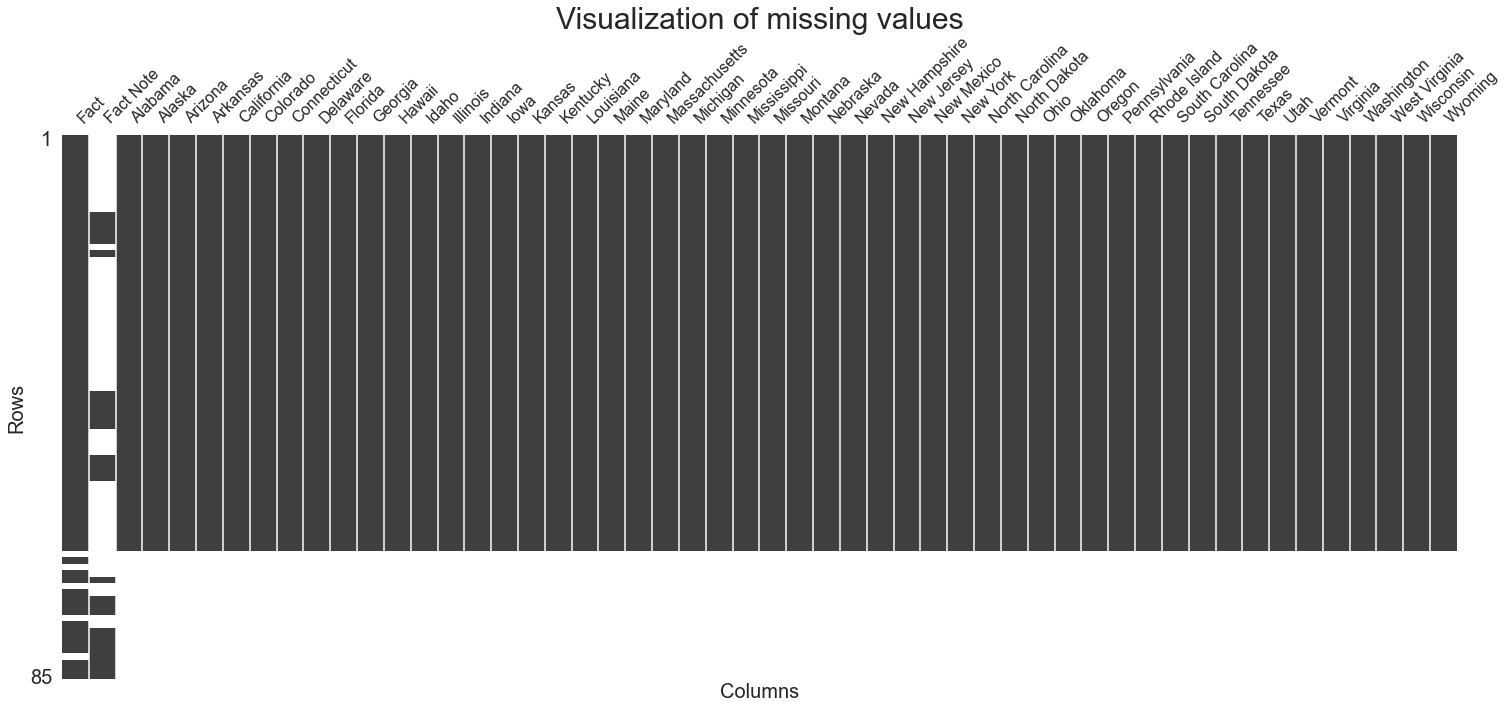

In [5]:
plot_missing_values(census_df)

Visualization above shows that `Fact Note` has a lot of missing values and other missing values across all other columns came from the lower part of the dataset. 

In [6]:
census_df.tail(30)

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
55,"All firms, 2012",NaN,"374,153","68,032","499,926","231,959","3,548,449","547,352","326,693","73,418","2,100,187","929,864","118,454","146,642","1,135,017","479,059","259,121","239,118","331,546","414,291","139,570","531,953","607,664","834,087","489,494","235,454","491,606","112,419","164,089","227,156","131,638","792,088",151363,2008988,805985,68270,904814,327229,339305,975453,94642,367726,81314,550453,"2,356,748","251,419","75,827","653,193","541,522","114,435","432,980","62,427"
56,"Men-owned firms, 2012",NaN,"203,604","35,402","245,243","123,158","1,852,580","284,554","187,845","38,328","1,084,885","480,578","60,409","70,438","609,648","253,533","135,382","125,169","184,154","215,111","79,243","276,630","357,158","446,128","268,710","125,079","257,948","55,913","83,696","114,057","76,716","464,592",71132,1139910,435677,37016,510078,174395,165691,579400,54651,202446,42418,302249,"1,251,696","132,163","41,270","353,012","262,650","63,112","236,252","30,039"
57,"Women-owned firms, 2012",NaN,"137,630","22,141","182,425","75,962","1,320,085","194,508","106,678","23,964","807,817","376,506","44,453","45,121","417,500","162,798","82,345","77,194","106,011","151,114","42,067","209,119","199,210","306,986","157,821","89,159","162,616","35,449","51,936","82,508","38,525","252,944",59044,725709,287058,20316,306824,105168,123015,304803,30484,131856,23722,195694,"866,678","76,269","23,417","236,290","187,677","39,065","133,859","19,344"
58,"Minority-owned firms, 2012",NaN,"92,219","13,688","135,313","35,982","1,619,857","85,849","56,113","14,440","926,112","371,588","74,208","10,592","311,684","61,252","14,707","26,127","27,258","126,100","4,339","203,394","89,967","158,946","47,302","74,824","61,035","5,578","14,571","71,864","6,111","237,242",60622,709021,183380,3190,122653,64875,41456,131512,14737,83233,4101,105234,"1,070,392","24,423","2,354","185,043","92,807","5,777","40,507","4,077"
59,"Nonminority-owned firms, 2012",NaN,"272,651","51,147","344,981","189,029","1,819,107","442,365","259,614","54,782","1,121,749","538,893","38,510","130,973","795,129","405,090","236,561","204,562","296,155","277,676","131,322","314,902","499,959","657,237","428,716","155,094","415,972","102,746","144,122","144,944","121,297","533,808",83857,1248304,603182,62271,759569,249027,285028,818858,77042,276269,74228,434025,"1,224,845","218,826","70,491","450,109","426,697","104,785","379,934","55,397"
60,"Veteran-owned firms, 2012",NaN,"41,943","7,953","46,780","25,915","252,377","51,722","31,056","7,206","185,756","96,787","11,148","12,804","89,110","45,174","25,889","21,610","33,208","42,211","15,689","50,976","58,339","71,861","45,582","26,789","49,217","11,486","16,693","23,049","16,119","57,996",14096,137532,86571,6584,91316,36273,30918,97969,9904,47987,8604,59379,"213,590","18,754","8,237","76,434","49,331","12,912","39,830","6,470"
61,"Nonveteran-owned firms, 2012",NaN,"316,984","56,091","427,582","192,988","3,176,341","469,524","281,182","60,318","1,846,686","800,585","101,334","124,314","1,006,885","412,543","217,779","203,401","282,704","354,460","115,839","462,232","525,667","733,517","419,628","198,566","415,542","93,393","137,254","191,293","108,817","707,975",128693,1811544,684743,56904,776193,273491,288790,837792,79837,303137,66219,469392,"2,057,218","219,807","63,317","548,439","461,401","94,960","370,755","51,353"
62,"Population per square mile, 2010",NaN,94.4,1.2,56.3,56,239.1,48.5,738.1,460.8,350.6,168.4,211.8,19,231.1,181,54.5,34.9,109.9,104.9,43.1,594.8

Further investigation that the `NaN`s started from row 65 which is actually the 20th values from the bottom of the dataset. We will go ahead and drop all null values

In [7]:
index_to_drop = census_df.iloc[-20:,:].index.tolist()
census_df.drop(index_to_drop,inplace=True)
census_df.drop("Fact Note",1,inplace=True)

The dataset seems inverted. The dataset has feature-like properties listed as rows and the states listed as columns. To put things in order and get into form for the second dataset. We have to beat it to shape.

In [8]:
census_df = census_df.set_index("Fact").T
census_df.reset_index(inplace=True)

In [9]:
overview(census_df)

There are no missing values
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 66 columns):
 #   Column                                                                                  Non-Null Count  Dtype 
---  ------                                                                                  --------------  ----- 
 0   index                                                                                   50 non-null     object
 1   Population estimates, July 1, 2016,  (V2016)                                            50 non-null     object
 2   Population estimates base, April 1, 2010,  (V2016)                                      50 non-null     object
 3   Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)   50 non-null     object
 4   Population, Census, April 1, 2010                                                       50 non-null     object
 5   P

Fact,index,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, April 1, 2010","Female persons, percent, July 1, 2016, (V2016)","Female persons, percent, April 1, 2010","White alone, percent, July 1, 2016, (V2016)","Black or African American alone, percent, July 1, 2016, (V2016)","American Indian and Alaska Native alone, percent, July 1, 2016, (V2016)","Asian alone, percent, July 1, 2016, (V2016)","Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016, (V2016)","Two or More Races, percent, July 1, 2016, (V2016)","Hispanic or Latino, percent, July 1, 2016, (V2016)","White alone, not Hispanic or Latino, percent, July 1, 2016, (V2016)","Veterans, 2011-2015","Foreign born persons, percent, 2011-2015","Housing units, July 1, 2016, (V2016)","Housing units, April 1, 2010","Owner-occupied housing unit rate, 2011-2015","Median value of owner-occupied housing units, 2011-2015","Median selected monthly owner costs -with a mortgage, 2011-2015","Median selected monthly owner costs -without a mortgage, 2011-2015","Median gross rent, 2011-2015","Building permits, 2016","Households, 2011-2015","Persons per household, 2011-2015","Living in same house 1 year ago, percent of persons age 1 year+, 2011-2015","Language other than English spoken at home, percent of persons age 5 years+, 2011-2015","High school graduate or higher, percent of persons age 25 years+, 2011-2015","Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015","With a disability, under age 65 years, percent, 2011-2015","Persons without health insurance, under age 65 years, percent","In civilian labor force, total, percent of population age 16 years+, 2011-2015","In civilian labor force, female, percent of population age 16 years+, 2011-2015","Total accommodation and food services sales, 2012 ($1,000)","Total health care and social assistance receipts/revenue, 2012 ($1,000)","Total manufacturers shipments, 2012 ($1,000)","Total merchant wholesaler sales, 2012 ($1,000)","Total retail sales, 2012 ($1,000)","Total retail sales per capita, 2012","Mean travel time to work (minutes), workers age 16 years+, 2011-2015","Median household income (in 2015 dollars), 2011-2015","Per capita income in past 12 months (in 2015 dollars), 2011-2015","Persons in poverty, percent","Total employer establishments, 2015","Total employment, 2015","Total annual payroll, 2015 ($1,000)","Total employment, percent change, 2014-2015","Total nonemployer establishments, 2015","All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010",FIPS Code
0,Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,51.60%,51.50%,69.30%,26.80%,0.70%,1.40%,0.10%,1.60%,4.20%,65.80%,"363,170",3.50%,"2,230,185","2,171,853",68.70%,"$125,500","$1,139",$345,$717,"15,001","1,848,325",2.55,85.30%,5.20%,84.30%,23.50%,11.80%,10.70%,58.00%,53.00%,"7,576,462","26,039,632","124,809,759","57,746,565","58,564,965","$12,145",24.4,"$43,623","$24,091",17.10%,"98,540","1,634,391","67,370,353",1.90%,"322,025","374,153","203,604","137,630","92,219","272,651","41,943","316,984",94.4,"50,645.33","""01"""
1,Alaska,"741,894","710,249",4.50%,"710,231",7.30%,7.60%,25.20%,26.40%,10.40%,7.70%,47.70%,48.00%,66.10%,3.80%,15.20%,6.30%,1.30%,7.30%,7.00%,61.20%,"69,323",7.40%,"310,658","306,967",63.40%,"$250,000","$1,827",$554,"$1,14

The feature space is to large and complicated. It better to keep it small and select only columns that would help the analysis and also rename the selected columns to something shorter that we can work with.

In [10]:
cols_to_keep = [
    "index",
    "Population estimates base, April 1, 2010,  (V2016)",
    "Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)",
    "Persons under 18 years, percent, July 1, 2016,  (V2016)",
    "Female persons, percent,  July 1, 2016,  (V2016)",
    "Housing units,  July 1, 2016,  (V2016)",
    "Persons  without health insurance, under age 65 years, percent",
    "Persons in poverty, percent"
]
cols_to_drop = census_df.columns.difference(cols_to_keep)
census_df.drop(cols_to_drop,1,inplace=True)

In [11]:
column_mapper = {
    "index":"state",
    "Population estimates base, April 1, 2010,  (V2016)": "population_est",
    "Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)": "percent_pop_change",
    "Persons under 18 years, percent, July 1, 2016,  (V2016)": "percent_adult",
    "Female persons, percent,  July 1, 2016,  (V2016)": "percent_female",
    "Housing units,  July 1, 2016,  (V2016)": "house_unit",
    "Persons  without health insurance, under age 65 years, percent": "percent_old_no_ins",
    "Persons in poverty, percent": "percent_poverty"
}

census_df.rename(columns=column_mapper,inplace=True)

In [12]:
overview(census_df)

There are no missing values
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   state               50 non-null     object
 1   population_est      50 non-null     object
 2   percent_pop_change  50 non-null     object
 3   percent_adult       50 non-null     object
 4   percent_female      50 non-null     object
 5   house_unit          50 non-null     object
 6   percent_old_no_ins  50 non-null     object
 7   percent_poverty     50 non-null     object
dtypes: object(8)
memory usage: 3.2+ KB
None
--------------------------------------------------
The dataset has 50 rows and 8 columns
--------------------------------------------------


Fact,state,population_est,percent_pop_change,percent_adult,percent_female,house_unit,percent_old_no_ins,percent_poverty
0,Alabama,"4,780,131",1.70%,22.60%,51.60%,"2,230,185",10.70%,17.10%
1,Alaska,"710,249",4.50%,25.20%,47.70%,"310,658",15.50%,9.90%
2,Arizona,"6,392,301",8.40%,23.50%,50.30%,"2,961,003",11.90%,16.40%
3,Arkansas,"2,916,025",2.50%,23.60%,50.90%,"1,354,762",9.30%,17.20%
4,California,"37,254,522",5.40%,23.20%,50.30%,"14,060,525",8.30%,14.30%


The dataset above has variable in a wrong datatype so we have to correct that

In [13]:
census_df["population_est"] = census_df["population_est"].str.replace(",","").astype(int)
census_df["percent_pop_change"] = census_df["percent_pop_change"].str.replace("%","").astype(float)
census_df["percent_adult"] = census_df["percent_adult"].str.replace("%","").astype(float)
census_df["percent_female"] = census_df["percent_female"].str.replace("%","").astype(float)
census_df["house_unit"] = census_df["house_unit"].str.replace(",","").astype(int)
census_df["percent_old_no_ins"] = census_df["percent_old_no_ins"].str.replace("%","").astype(float)
census_df["percent_poverty"] = census_df["percent_poverty"].str.replace("%","").astype(float)

In [14]:
overview(census_df)

There are no missing values
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               50 non-null     object 
 1   population_est      50 non-null     int64  
 2   percent_pop_change  50 non-null     float64
 3   percent_adult       50 non-null     float64
 4   percent_female      50 non-null     float64
 5   house_unit          50 non-null     int64  
 6   percent_old_no_ins  50 non-null     float64
 7   percent_poverty     50 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 3.2+ KB
None
--------------------------------------------------
The dataset has 50 rows and 8 columns
--------------------------------------------------


Fact,state,population_est,percent_pop_change,percent_adult,percent_female,house_unit,percent_old_no_ins,percent_poverty
0,Alabama,4780131,1.7,22.6,51.6,2230185,10.7,17.1
1,Alaska,710249,4.5,25.2,47.7,310658,15.5,9.9
2,Arizona,6392301,8.4,23.5,50.3,2961003,11.9,16.4
3,Arkansas,2916025,2.5,23.6,50.9,1354762,9.3,17.2
4,California,37254522,5.4,23.2,50.3,14060525,8.3,14.3


#### Second dataset

In [15]:
overview(gun_df)

There are 154595 missing values
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      12485 non-null  object 
 1   state                      12485 non-null  object 
 2   permit                     12461 non-null  float64
 3   permit_recheck             1100 non-null   float64
 4   handgun                    12465 non-null  float64
 5   long_gun                   12466 non-null  float64
 6   other                      5500 non-null   float64
 7   multiple                   12485 non-null  int64  
 8   admin                      12462 non-null  float64
 9   prepawn_handgun            10542 non-null  float64
 10  prepawn_long_gun           10540 non-null  float64
 11  prepawn_other              5115 non-null   float64
 12  redemption_handgun 

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,redemption_handgun,redemption_long_gun,redemption_other,returned_handgun,returned_long_gun,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,21.0,2.0,1378.0,1262.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,2.0,0.0,200.0,154.0,2.0,28.0,30.0,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,6.0,0.0,1474.0,748.0,3.0,82.0,5.0,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,13.0,0.0,1296.0,1824.0,4.0,0.0,0.0,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,0.0,0.0,535.0,397.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


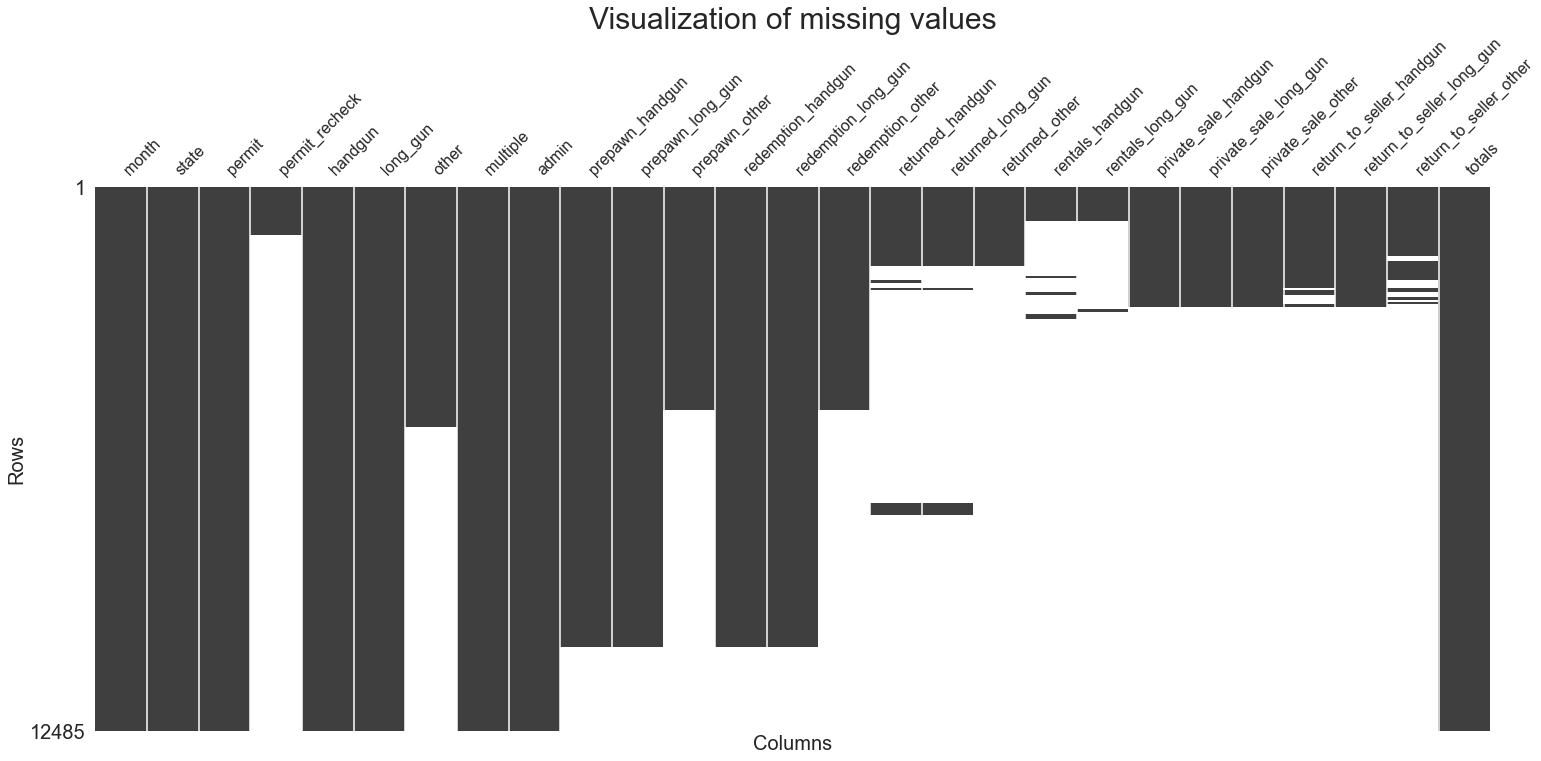

In [16]:
plot_missing_values(gun_df)

In [17]:
cols_to_drop = gun_df.columns.difference(["month","state","totals"])
gun_df.drop(cols_to_drop,1,inplace=True)
gun_df.head()

,month,state,totals
0,2017-09,Alabama,32019
1,2017-09,Alaska,6303
2,2017-09,Arizona,28394
3,2017-09,Arkansas,17747
4,2017-09,California,123506


In [18]:
overview(gun_df)

There are no missing values
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   month   12485 non-null  object
 1   state   12485 non-null  object
 2   totals  12485 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 292.7+ KB
None
--------------------------------------------------
The dataset has 12485 rows and 3 columns
--------------------------------------------------


,month,state,totals
0,2017-09,Alabama,32019
1,2017-09,Alaska,6303
2,2017-09,Arizona,28394
3,2017-09,Arkansas,17747
4,2017-09,California,123506


The Datetime column has the wrong datatype so we will correct that. Also, we are analysing yearly data and not monthly data. We have to organised the data into the desired format

In [19]:
gun_df.month = pd.to_datetime(gun_df.month,format="%Y/%m")

In [20]:
gun_df["year"] = gun_df.month.dt.year
gun_df.drop("month",1,inplace=True)

In [21]:
gun_df = gun_df.groupby(["state","year"],as_index=False).totals.sum()
gun_df

,state,year,totals
0,Alabama,1998,36568
1,Alabama,1999,246756
2,Alabama,2000,221911
3,Alabama,2001,230187
4,Alabama,2002,221008
...,...,...,...
1095,Wyoming,2013,70671
1096,Wyoming,2014,63063
1097,Wyoming,2015,62339
1098,Wyoming,2016,63594


In [22]:
overview(gun_df)

There are no missing values
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   state   1100 non-null   object
 1   year    1100 non-null   int64 
 2   totals  1100 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 25.9+ KB
None
--------------------------------------------------
The dataset has 1100 rows and 3 columns
--------------------------------------------------


,state,year,totals
0,Alabama,1998,36568
1,Alabama,1999,246756
2,Alabama,2000,221911
3,Alabama,2001,230187
4,Alabama,2002,221008


In [23]:
gun_df = pd.concat([gun_df,gun_df.rename(columns={"totals":"previous_totals"}).shift()["previous_totals"]],axis=1)
gun_df.head()

,state,year,totals,previous_totals
0,Alabama,1998,36568,NaN
1,Alabama,1999,246756,36568.0
2,Alabama,2000,221911,246756.0
3,Alabama,2001,230187,221911.0
4,Alabama,2002,221008,230187.0


In [24]:
rows_to_drop = gun_df.query("year != 2016").index.tolist()
gun_df.drop(rows_to_drop,0,inplace=True)
gun_df.reset_index(inplace=True,drop=True)
gun_df.head()

,state,year,totals,previous_totals
0,Alabama,2016,616947,737509.0
1,Alaska,2016,87647,85621.0
2,Arizona,2016,416279,331442.0
3,Arkansas,2016,266014,257346.0
4,California,2016,2377167,1761079.0


In [25]:
gun_df["gun_interest_change"] = ((gun_df.totals - gun_df.previous_totals)/gun_df.previous_totals)*100
gun_df.drop(["previous_totals","year"],1,inplace=True)

In [26]:
overview(gun_df)

There are no missing values
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                55 non-null     object 
 1   totals               55 non-null     int64  
 2   gun_interest_change  55 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.4+ KB
None
--------------------------------------------------
The dataset has 55 rows and 3 columns
--------------------------------------------------


,state,totals,gun_interest_change
0,Alabama,616947,-16.347190
1,Alaska,87647,2.366242
2,Arizona,416279,25.596334
3,Arkansas,266014,3.368228
4,California,2377167,34.983553


We have 55 rows and this is weird because United states only has 50 states. So let's investigate that.

In [27]:
np.setdiff1d(gun_df.state.unique(),census_df.state.unique())

array(['District of Columbia', 'Guam', 'Mariana Islands', 'Puerto Rico',
       'Virgin Islands'], dtype=object)

A quick google search District of columbia(is the former name of the popular Washington DC) is the capital and it is not recognized as a state in America. Guam, Mariana Islands, Puerto Rico and Virgin Islands seems to be unincorporated US territory (never knew this kind of things existed). We will just drop all of this.

In [28]:
rows_to_drop = gun_df.query("state in ['District of Columbia', 'Guam', 'Mariana Islands', 'Puerto Rico','Virgin Islands']").index.tolist()
gun_df.drop(rows_to_drop,0,inplace=True)
gun_df.reset_index(inplace=True,drop=True)
gun_df.head()

,state,totals,gun_interest_change
0,Alabama,616947,-16.347190
1,Alaska,87647,2.366242
2,Arizona,416279,25.596334
3,Arkansas,266014,3.368228
4,California,2377167,34.983553


In [29]:
overview(gun_df)

There are no missing values
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                50 non-null     object 
 1   totals               50 non-null     int64  
 2   gun_interest_change  50 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ KB
None
--------------------------------------------------
The dataset has 50 rows and 3 columns
--------------------------------------------------


,state,totals,gun_interest_change
0,Alabama,616947,-16.347190
1,Alaska,87647,2.366242
2,Arizona,416279,25.596334
3,Arkansas,266014,3.368228
4,California,2377167,34.983553


#### Final Dataset

In [30]:
df = pd.merge(census_df,gun_df,on="state")
df.head()

,state,population_est,percent_pop_change,percent_adult,percent_female,house_unit,percent_old_no_ins,percent_poverty,totals,gun_interest_change
0,Alabama,4780131,1.7,22.6,51.6,2230185,10.7,17.1,616947,-16.347190
1,Alaska,710249,4.5,25.2,47.7,310658,15.5,9.9,87647,2.366242
2,Arizona,6392301,8.4,23.5,50.3,2961003,11.9,16.4,416279,25.596334
3,Arkansas,2916025,2.5,23.6,50.9,1354762,9.3,17.2,266014,3.368228
4,California,37254522,5.4,23.2,50.3,14060525,8.3,14.3,2377167,34.983553


In [31]:
overview(df)

There are no missing values
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                50 non-null     object 
 1   population_est       50 non-null     int64  
 2   percent_pop_change   50 non-null     float64
 3   percent_adult        50 non-null     float64
 4   percent_female       50 non-null     float64
 5   house_unit           50 non-null     int64  
 6   percent_old_no_ins   50 non-null     float64
 7   percent_poverty      50 non-null     float64
 8   totals               50 non-null     int64  
 9   gun_interest_change  50 non-null     float64
dtypes: float64(6), int64(3), object(1)
memory usage: 4.3+ KB
None
--------------------------------------------------
The dataset has 50 rows and 10 columns
--------------------------------------------------


,state,population_est,percent_pop_change,percent_adult,percent_female,house_unit,percent_old_no_ins,percent_poverty,totals,gun_interest_change
0,Alabama,4780131,1.7,22.6,51.6,2230185,10.7,17.1,616947,-16.347190
1,Alaska,710249,4.5,25.2,47.7,310658,15.5,9.9,87647,2.366242
2,Arizona,6392301,8.4,23.5,50.3,2961003,11.9,16.4,416279,25.596334
3,Arkansas,2916025,2.5,23.6,50.9,1354762,9.3,17.2,266014,3.368228
4,California,37254522,5.4,23.2,50.3,14060525,8.3,14.3,2377167,34.983553


In [32]:
df.describe()

,population_est,percent_pop_change,percent_adult,percent_female,house_unit,percent_old_no_ins,percent_poverty,totals,gun_interest_change
count,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.00000,5.000000e+01,50.000000
mean,6.163127e+06,3.120700,17.425780,38.511740,2.707684e+06,7.078540,10.05498,5.481110e+05,16.709562
std,6.848463e+06,3.366857,9.936137,21.584467,2.813244e+06,5.044314,6.26358,6.826073e+05,13.395472
min,5.637670e+05,-1.200000,0.197000,0.487000,2.706000e+05,0.051000,0.10700,1.668100e+04,-16.347190
25%,1.833003e+06,0.069250,19.025000,48.000000,8.420270e+05,3.225000,7.80000,1.500798e+05,8.339029
50%,4.436412e+06,2.050000,22.250000,50.300000,2.001266e+06,7.050000,11.35000,3.212000e+05,14.661885
75%,6.680362e+06,5.075000,23.450000,50.900000,3.009514e+06,10.100000,14.25000,6.159565e+05,24.656256
max,3.725452e+07,10.800000,30.200000,51.600000,1.406052e+07,18.600000,20.80000,3.676847e+06,54.246680


In [33]:
df.duplicated().any()

False

<a id='eda'></a>
## Exploratory Data Analysis


### Question 1: What are the most populated states in USA?

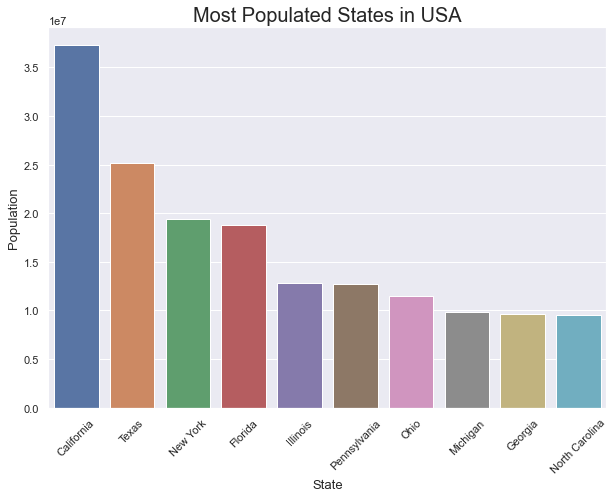

In [34]:
plot_bar(
    "state",
    "population_est",
    df.sort_values("population_est",ascending=False).head(10),
    ["State","Population"],
    "Most Populated States in USA",
    rotate=True,
    annotate=False
);

The visualization above shows that most populated states in America. California comes in first place by a mile, then Texas, then New York which is followed very closely by Florida and then Illinois.

### Question 2: What states has grown the most in the past year?

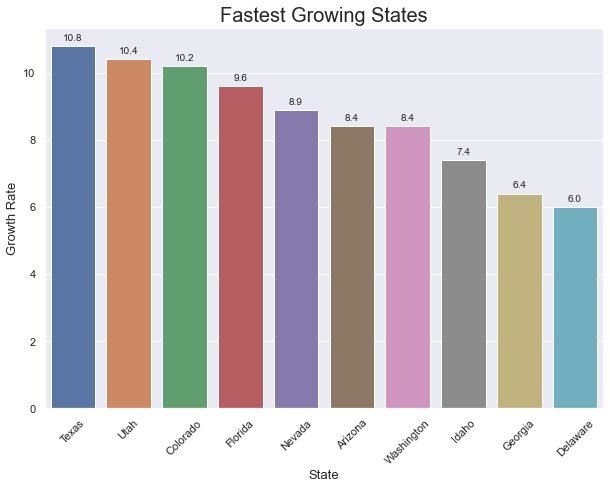

In [35]:
plot_bar(
    "state",
    "percent_pop_change",
    df.sort_values("percent_pop_change",ascending=False).head(10),
    ["State","Growth Rate"],
    "Fastest Growing States",
    rotate=True,
    annotate=True
);

Texas seems to have lot of potential in terms of population given that it is the second most populous state. Texas is also the second largest state after Alaska.

### Question 3: Given the growth rate and current population, what could the population look like in 10 years?

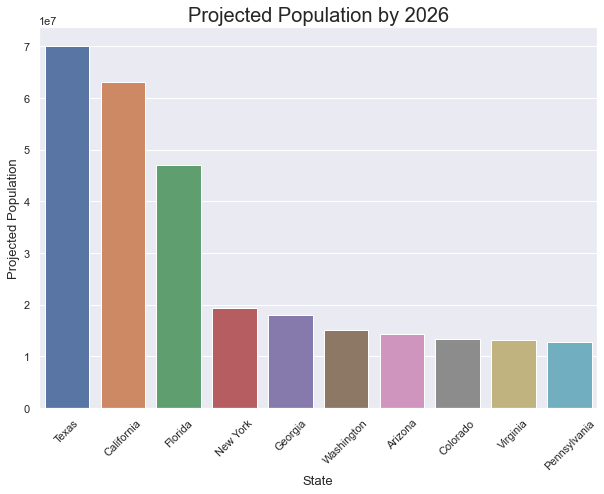

In [37]:
df["projected_pop"] = predict_population(df.population_est,df.percent_pop_change/100)
plot_bar(
    "state",
    "projected_pop",
    df.sort_values("projected_pop",ascending=False).head(10),
    ["State","Projected Population"],
    "Projected Population by 2026",
    rotate=True,
    annotate=False
);

Just like we said earlier, Texas potential is most likely going to come to fruition. In 2026, if the states maintain the growth rate, we would see Texas, California and Florida way ahead of the others in terms of population.

### Question 4: What are the poorest states in USA?

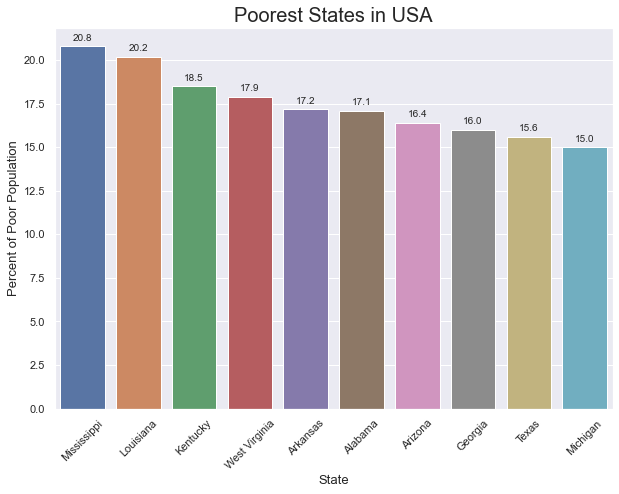

In [39]:
plot_bar(
    "state",
    "percent_poverty",
    df.sort_values("percent_poverty",ascending=False).head(10),
    ["State","Percent of Poor Population"],
    "Poorest States in USA",
    rotate=True,
    annotate=True
);

Mississippi comes off as the poorest countries which a lot of people think it's an offshoot of racism, poor education/lack of educated people, etc

### Question 3: What has the most gun interest?

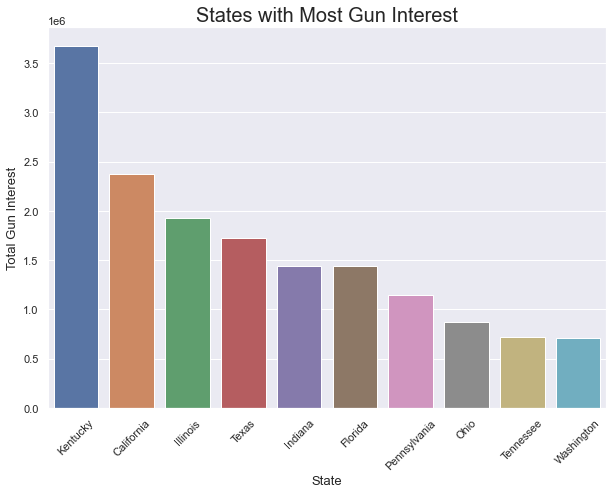

In [40]:
plot_bar(
    "state",
    "totals",
    df.sort_values("totals",ascending=False).head(10),
    ["State","Total Gun Interest"],
    "States with Most Gun Interest",
    rotate=True,
    annotate=False
);

Kentucky is way above the other states in terms of gun interest. This might be attributed to the fact that there are [no regulation restricting bulk purchases in kentucky](https://giffords.org/lawcenter/state-laws/bulk-gun-purchases-in-kentucky/).

### Question 4: Does more population mean more gun interest?

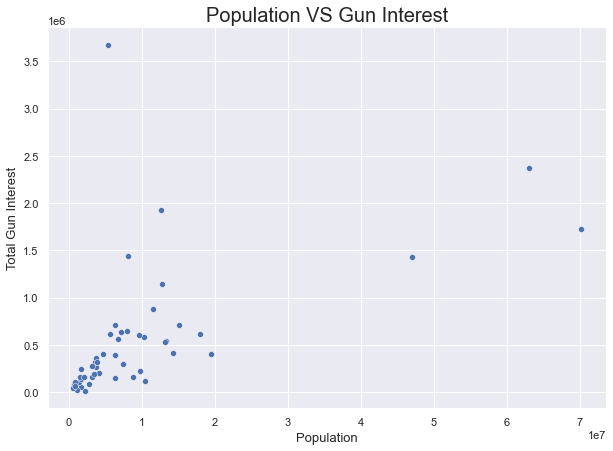

In [41]:
plot_scatter(
    "population_est",
    "totals",
    df,
    ["Population","Total Gun Interest"],
    "Population VS Gun Interest"
);

In [47]:
df.population_est.corr(df.totals)

0.6070047969890804

Given the similarity(states) common to both population and gun interest bar charts above. It only right to find out if more population accommodates more gun interests. Given the chart above we can see there is a very good correlation between both factors. It's important to note that more population cannot be stated to be the cause of more gun interest. 

### Question 5: Do poor people deem it necessary to own a gun?

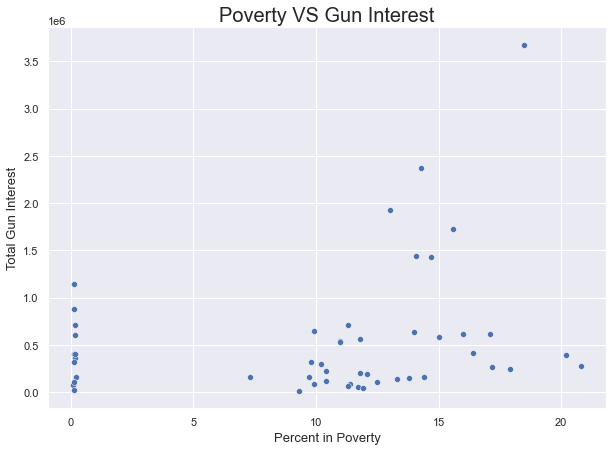

In [42]:
plot_scatter(
    "percent_poverty",
    "totals",
    df,
    ["Percent in Poverty","Total Gun Interest"],
    "Poverty VS Gun Interest"
);

It expected that poor people shouldn't have a gun as [owning a gun is deemed to be a luxury](https://www.gq.com/story/gun-ownership-cost). However from the chart above we can see there is no evidence of any sort of strong trend whether negative or positive.

### Question 6: Do women also fancy owning guns?

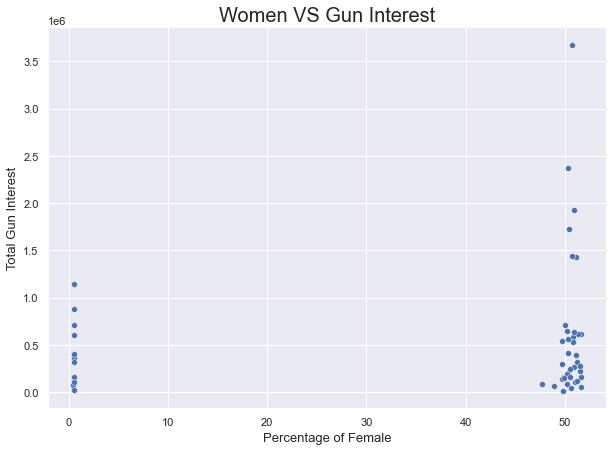

In [43]:
plot_scatter(
    "percent_female",
    "totals",
    df,
    ["Percentage of Female","Total Gun Interest"],
    "Women VS Gun Interest"
);

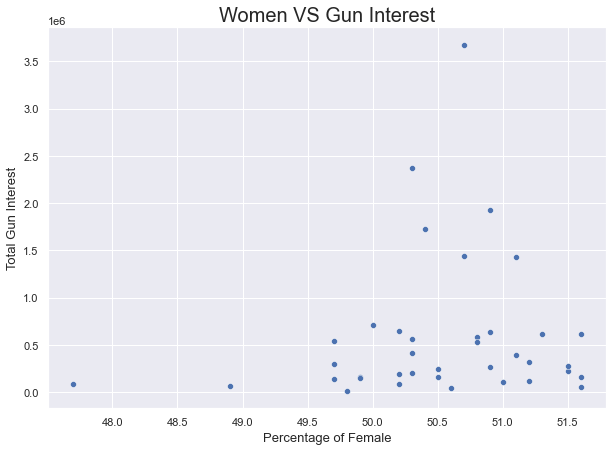

In [44]:
plot_scatter(
    "percent_female",
    "totals",
    df.query("percent_female > 5"),
    ["Percentage of Female","Total Gun Interest"],
    "Women VS Gun Interest"
);

Given that this chart is percentage of female is a subtle representation of male. We can agree from the chart above there is no significant relationship between gender and gun interest.

### Question 7: Women, Poverty?🤔

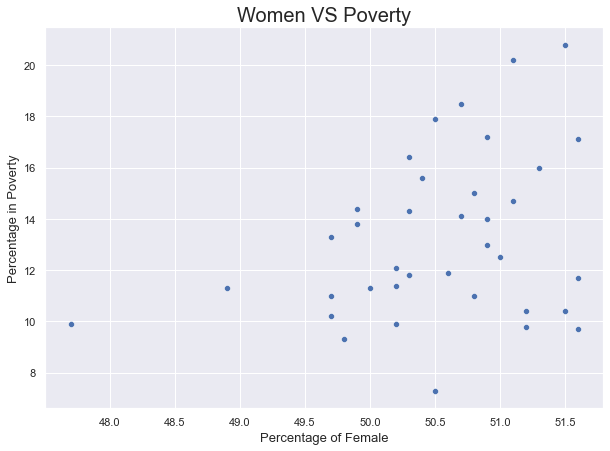

In [45]:
plot_scatter(
    "percent_female",
    "percent_poverty",
    df.query("percent_female > 5"),
    ["Percentage of Female","Percentage in Poverty"],
    "Women VS Poverty"
);

Given that the chart `Poverty VS Gun Interest` and `Women Vs Gun Interest` were very similar, it worth investigating the trends between poverty and women. The chart above shows a very strong correlation between female population and poverty. While we can not conclude on causation, it's surprising that in a country as developed as America women are still synonymous with poverty.

<a id='conclusions'></a>
## Conclusions

- Texas has so much potential in terms of human resources. 
- Stricter gun laws would definitely affect interest in owning guns. 
- There is no serious relationship between gender and interest in guns.

Disclaimer: Whatever was analysed in this dataset may only hold value for the year 2016. Things may have changed since then.